# Performing Logistic Regression
### in order to build a Predictor of the release year

In this notebook, we will be using the scikit-learn library to perform a logistic regression on the data

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from tueplots import bundles


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt_settings = bundles.neurips2021(usetex=False)
plt_settings['figure.constrained_layout.use'] = False
plt.rcParams.update(plt_settings)

fig_width, fig_height = plt_settings['figure.figsize']
print(plt_settings)

{'text.usetex': False, 'font.serif': ['Times New Roman'], 'mathtext.fontset': 'stix', 'mathtext.rm': 'Times New Roman', 'mathtext.it': 'Times New Roman:italic', 'mathtext.bf': 'Times New Roman:bold', 'font.family': 'sans-serif', 'figure.figsize': (5.499999861629998, 3.399186852607058), 'figure.constrained_layout.use': False, 'figure.autolayout': False, 'font.size': 9, 'axes.labelsize': 9, 'legend.fontsize': 7, 'xtick.labelsize': 7, 'ytick.labelsize': 7, 'axes.titlesize': 9}


In [2]:
### import the datasets
train = pd.read_csv('../dat/train_set.csv')
test = pd.read_csv('../dat/test_set.csv')

In [3]:
polynomial_degree = -1

# helper func to put the data into bucket of timespans
timespan=1
min_year=1990

def calc_labels(years):
    return np.array([int((year-min_year)/timespan) for year in years])

def calc_years_from_label(label):
    start_year = label * timespan + min_year
    end_year = start_year + timespan - 1
    return start_year, end_year

This cell sorts the data and does some preprocessing, in order for the regression to work

In [4]:
predictors = ['explicit', 'danceability', 'energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

X_train = train[predictors]
X_test = test[predictors]

scaler = preprocessing.StandardScaler().fit(pd.concat([train, test])[predictors])

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

y_train = calc_labels(train['year'])
y_test = calc_labels(test['year'])

In [5]:
if polynomial_degree != -1:
    poly = preprocessing.PolynomialFeatures(degree = polynomial_degree, interaction_only=False, include_bias=False)
    X_train = poly.fit_transform(X_train)
    X_test = poly.transform(X_test)

In [6]:
reg = LogisticRegression().fit(X_train, y_train)

In [7]:
reg.coef_.shape

(31, 12)

Fitting the sklearn Logistic Regression Model 

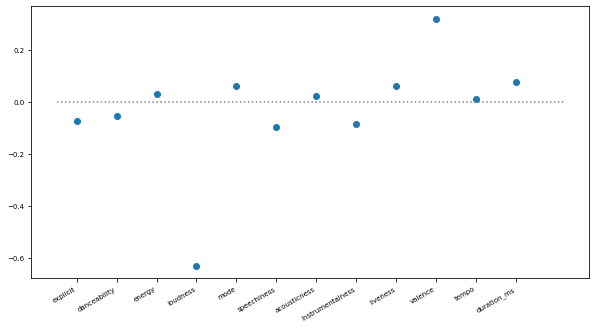

In [8]:
if polynomial_degree == -1:
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(predictors, reg.coef_[0])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    #ax.set_ylim([-1,1])
    ax.hlines(0,-.5, 12.2, colors='grey', linestyle='dotted')
    plt.show()

In [9]:
predicted_values = reg.predict(X_test)
random_values = np.random.randint(y_test.max(), size=(10,) + y_test.shape)

print(f'L1 Error of random: {np.array([np.abs(random - y_test).mean() for random in random_values]).mean()}')
print(f'L1 Error of predictor: {np.abs(predicted_values - y_test).mean()}')
print(f'L2 Error of random: {np.array([((random - y_test)**2).mean() for random in random_values]).mean()}')
print(f'L2 Error of predictor: {((predicted_values - y_test)**2).mean()}')
print(f'Accuracy of random: {np.array([np.sum(random == y_test)/len(y_test) for random in random_values]).mean()}')
print(f'Accuracy of predictor: {reg.score(X_test, y_test)}')

L1 Error of random: 10.120158743332912
L1 Error of predictor: 7.596680980067534
L2 Error of random: 153.77123792716327
L2 Error of predictor: 95.03533939359522
Accuracy of random: 0.03126597152754419
Accuracy of predictor: 0.07890862866553383


In [10]:
# for i, coef in enumerate(reg.coef_):
#     sorted_ids = np.flip(np.argsort(np.abs(coef)))
#     start_year, end_year = calc_years_from_label(i)
#     print(f'timespan {i}: \n  years: {start_year}-{end_year} \n  tracks:{sum(y_test == i)} ')
#     for index in sorted_ids:    
#         print(f'     {predictors[index]}: {round(coef[index], 3)}')
# 

In [11]:
if polynomial_degree == -1:
    # save reg.coef_ for plotting
    pd.DataFrame(reg.coef_).to_csv('../dat/log_reg_coef.csv')

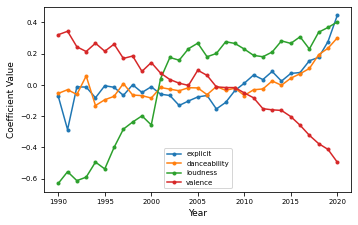

In [12]:
# Old plotting 

interesting_features = ['explicit', 'danceability','loudness','valence']

fig, ax = plt.subplots(figsize=(fig_width, fig_height))

year_series = np.unique((np.unique(train['year'])))

for i,feature in enumerate(predictors):
    if feature in interesting_features:
        ax.plot(year_series, reg.coef_[:,i], '.-', label=feature)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Coefficient Value')
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")
#plt.savefig('../figs/log_coefs.pdf',bbox_inches='tight')
plt.show()

The following cell plots one of the figures for the report. Unfortunately it is very messy, due to many custom settings

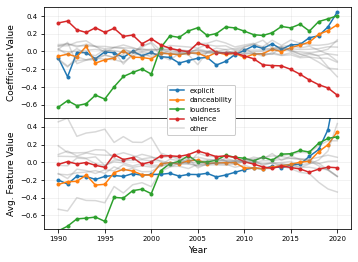

In [13]:
fig = plt.figure(figsize=(fig_width, fig_height*1.2))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
ax1, ax2 = axs

year_series = np.unique((np.unique(train['year'])))

for i,feature in enumerate(predictors):
    if feature in interesting_features:
        ax1.plot(year_series, reg.coef_[:,i], '.-', label=feature,)
    else:
        ax1.plot(year_series, reg.coef_[:,i], '-', alpha=.3,color='grey')
    


train_ = train[predictors + ['year']]
train_[predictors] = preprocessing.StandardScaler().fit_transform(train_[predictors])

tracks_by_year_avg = train_.groupby('year').mean()


for i,feature in enumerate(predictors[:-1]):
    if feature in interesting_features:    
        ax2.plot(year_series,tracks_by_year_avg[feature], '.-',label=feature )
    else:
        ax2.plot(year_series,tracks_by_year_avg[feature], '-', alpha=.3, color='grey')
ax2.plot(year_series,tracks_by_year_avg[predictors[-1]], '-', alpha=.3, color='grey', label='other')


ax2.set_xlabel('Year')
ax2.set_ylabel('Avg. Feature Value')
ax1.set_ylabel('Coefficient Value')
for ax in axs:
    #ax.label_outer()
    ax.set_ylim(-.75, .5)
    ax.grid(alpha=.2)
ax2.legend(loc=(.4,0.85), framealpha=1)
#ax2.legend(loc= 'lower center')

ax1.tick_params(axis='x', which='both', bottom=False,labelbottom=False)

#plt.savefig('../figs/coefs_avg.pdf',bbox_inches='tight')
plt.show()